In [1]:
# ----------------------------------------------------------------------------
#
# TITLE - linear_model_ABC_proper_DR16.ipynb
# AUTHOR - James Lane
# PROJECT - AST 1501
#
# ----------------------------------------------------------------------------
#
# Docstrings and metadata:
'''Use the ABC method to estimate a posterior distribution on the parameters of the model. 
Meant to be exactly like linear_model_ABC.ipynb but with a slight change to the way in which 
the ABC method proceeds. Here DR16 data is used.
'''

__author__ = "James Lane"

In [2]:
# General
import numpy as np
import pdb, sys, importlib, copy, importlib, glob, pickle
from tqdm import tqdm_notebook

## Plotting
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib import colors
from matplotlib import cm

## Astropy
from astropy import units as apu
from astropy.io import fits
from astropy.table import Table

## Scipy
from scipy.stats import binned_statistic_2d, binned_statistic
from scipy import stats
from scipy import interpolate

## Galpy
from galpy import potential

## Add project-specific package. Assume relative location
sys.path.append('../../src/')
from ast1501.linear_model import LinearModel
# import ast1501.linear_model
import ast1501.potential

In [3]:
### Matplotlib for notebooks
%config InlineBackend.figure_format = 'retina'

# Meta

## Information:

## Future Work:
- Implement a function in ```LinearModel``` which samples its own bootstrap sample assuming Gaussian errors from the bootstrapping procedure.
- Write an ABC class?

# Prepare

## Outline of the Algorithm

Attempt to implement the ABC method on the data.
- Make a master linear model of the Gaia data and output the radial and phi location
- Sample $b/a \in [0.75,1.0]$ and $\phi_{B} \in [0,\pi/2)$ and compute the $v_{R}$ and $v_{T}$ velocity field using the ```kuijken_potential``` class at the locations specified by the master model.
- Perturb those velocities by the uncertainty in the measured velocities and stitch into a bootstrap-like array
- Make a new linear model and turn up the beatzzz

In [4]:
# Staircase plotting function
def staircase_plot(data,
                   data_labels,
                   fig = None,
                   ax = None,
                   use_kernel = False,
                   plot_ci = True):
    '''
    staircase_plot:
    
    Take in N variables in M samples and plot their correlations.
    
    Args:
        data (mxn array) - The input data. The first axis should be the sample 
            number and the second axis should be the variable
        data_labels (length n array) - The variable labels
        fig (matplotlib figure) - The input figure to plot on. If None then make 
            one [None].
        ax (matplotlib axis) - The input axis to plot on. If None then make one 
            [None].
        use_kernel (boolean) - Use a gaussian kernel for plotting? [False]
        plot_ci = (boolean) - Add confidence interval markers at the median and 
            68% CI? [True]
    
    Returns:
        fig, ax (matplotlib figure and axis object) - The matplotlib figure and 
            axis objects.
    '''
    
    # Figure out the number of variables
    n_var = len( data[0,:] )
    
    kde_bw = 0.75
    
    # Check if the figure was provided
    if fig == None:
        fig = plt.figure( figsize=( int(n_var+4), int(n_var+4) ) )
    ##fi
    if ax == None:
        axs = fig.subplots( nrows=n_var, ncols=n_var )
    ##fi
    
    # Double loop over the number of variables
    for i in range(n_var): # Indexes along columns (down)
        for j in range(n_var): # Indexes along rows (across)
            
            # Maxima and minima
            xmin = np.min(data[:,j]) - 0.1*np.median(data[:,j])
            xmax = np.max(data[:,j]) + 0.1*np.median(data[:,j])
            ymin = np.min(data[:,i]) - 0.1*np.median(data[:,i])
            ymax = np.max(data[:,i]) + 0.1*np.median(data[:,i])
            
            # If this is an upper-right plot its a duplicate, remove it
            if j > i:
                axs[i,j].set_axis_off()
                continue
                
            # If the two indices are equal just make a histogram of the data
            if j == i: 
                
                # Make and plot the kernel
                if use_kernel:
                    kernel = stats.gaussian_kde( data[:,i], bw_method=kde_bw )
                    kernel_grid = np.linspace( xmin, xmax, 1000 )
                    kernel_evaluate = kernel.evaluate( kernel_grid )
                    kernel_normalize = np.max(kernel_evaluate)
                    axs[i,j].plot( kernel_grid, kernel_evaluate/kernel_normalize, color='Black' ) 
                    axs[i,j].set_ylabel('KDE')
                else:
                    axs[i,j].hist( data[:,i], bins=25, histtype='step', color='Black' )
                    axs[i,j].set_ylabel('N')
                ##fi
                
                if plot_ci:
                    plot_median = np.median( data[:,i] )
                    plot_upper_68_ci = np.sort( data[:,i] )[ int((0.5+0.68/2)*len(data[:,i])) ]
                    plot_lower_68_ci = np.sort( data[:,i] )[ int((0.5-0.68/2)*len(data[:,i])) ]
                    axs[i,j].axvline(plot_median, linestyle='dashed', color='Black')
                    axs[i,j].axvline(plot_upper_68_ci, linestyle='dotted', color='Black')
                    axs[i,j].axvline(plot_lower_68_ci, linestyle='dotted', color='Black')
                ##fi
                    
                # Decorate
                axs[i,j].set_xlim( xmin, xmax)
                axs[i,j].tick_params(labelleft='off', labelright='on')
                axs[i,j].yaxis.set_label_position('right')
                
            # If the two indices are not equal make a scatter plot
            if j < i:
                # axs[i,j].scatter( data[:,j], data[:,i], s=4, color='Black', 
                #     alpha=0.3 )
                
                if use_kernel:
                    xx, yy = np.mgrid[ xmin:xmax:100j, ymin:ymax:100j ]
                    positions = np.vstack([ xx.ravel(), yy.ravel() ])
                    values = np.vstack([ data[:,j], data[:,i] ])
                    kernel = stats.gaussian_kde( values, bw_method=kde_bw )
                    kernel_evaluate = np.reshape( kernel(positions).T, xx.shape )

                    cfset = axs[i,j].contourf(xx, yy, kernel_evaluate, cmap='Blues',
                        alpha=0.75)
                    cset = axs[i,j].contour(xx, yy, kernel_evaluate, colors='Black',
                        linewidths=0.5)
                else:
                    axs[i,j].scatter(data[:,j], data[:,i], s=4, color='Black', 
                                     alpha=0.3 )
                ##ie
                
                if plot_ci:
                    plot_median_x = np.median( data[:,j] )
                    plot_upper_68_ci_x = np.sort( data[:,j] )[ int((0.5+0.68/2)*len(data[:,j])) ]
                    plot_lower_68_ci_x = np.sort( data[:,j] )[ int((0.5-0.68/2)*len(data[:,j])) ]
                    axs[i,j].axvline(plot_median_x, linestyle='dashed', color='Black')
                    axs[i,j].axvline(plot_upper_68_ci_x, linestyle='dotted', color='Black')
                    axs[i,j].axvline(plot_lower_68_ci_x, linestyle='dotted', color='Black')
                    
                    plot_median_y = np.median( data[:,i] )
                    plot_upper_68_ci_y = np.sort( data[:,i] )[ int((0.5+0.68/2)*len(data[:,i])) ]
                    plot_lower_68_ci_y = np.sort( data[:,i] )[ int((0.5-0.68/2)*len(data[:,i])) ]
                    axs[i,j].axhline(plot_median_y, linestyle='dashed', color='Black')
                    axs[i,j].axhline(plot_upper_68_ci_y, linestyle='dotted', color='Black')
                    axs[i,j].axhline(plot_lower_68_ci_y, linestyle='dotted', color='Black')
                ##fi
                
                axs[i,j].set_xlim( xmin, xmax)
                axs[i,j].set_ylim( ymin, ymax)
            
            
            # Make X axis
            if i == n_var-1:
                axs[i,j].set_xlabel( data_labels[j] )
            else:
                axs[i,j].tick_params(labelbottom='off')    
            
            # Make Y axis    
            if j == 0 and i!=0:
                axs[i,j].set_ylabel( data_labels[i] )
            else:
                axs[i,j].tick_params(labelleft='off')  
                
    return fig, axs            
#def

def check_pickle_filename(pickle_filename):
    files_with_prefix = glob.glob('./'+pickle_filename+'*')
    if len(files_with_prefix) > 0:
        user_input = input('This file ({}) might already exist, continue (y/n)? '\
            .format(pickle_filename))
        if user_input == 'y':
            pass
        elif user_input == 'n':
            raise RuntimeError('Abandon, dont want to overwrite file.')
        ##ei
    ##fi
#def

def make_data_like_bootstrap_samples(R, phi, vR, vT, phi_err=0.01, 
                                        vT_err=0.01, vR_err=0.01):
    '''make_data_like_bootstrap_samples:
    
    Take a series of R/phi data and velocities and knit it into a form that 
    looks like the bootstrap sample arrays, and which is appropriate for using 
    in the linear model functions.
    
    Args:
        R
        phi (float array) - Phi positions
        vT (float array) - Tangential velocities
        vR (float array) - Radial velocities
        phi_err (float array) - Phi position errors [None]
        vT_err (float array) - Tangential velocity errors [None]
        vR_err (float array) - Radial velocity errors [None]
        
    Returns:
        bs_samples_vT (N-array) - Array of the vR bootstrap sample results 
            for a single radius. It contains:
            - R_bin_cent (float) - Radial bin center
            - R_bin_size (float) - Radial bin size
            - vT (float array) - vT as a function of phi
            - vT_error (float array) - vT uncertainty as a function of phi
            - phi_bin_phi (float array) - phi bin centers
            - phi_bin_phi_err (float array) - phi bin center uncertainty
        bs_samples_vR (N-array) - same but for vT
    '''
    
    # Declare the arrays which hold the bootstrap samples
    bs_samples_vT = []
    bs_samples_vR = []
    
    # Find the unique bins
    unique_bins = np.unique(R)
    n_R_bins = len(unique_bins)
    
    # Loop over each unique radius and extract all the data for that bin
    for i in range(n_R_bins):
        
        this_R_bin_cent = unique_bins[i]
        where_unique_R = np.where(R==this_R_bin_cent)[0]
        this_phi = phi[where_unique_R]
        this_vT = vT[where_unique_R]
        this_vR = vR[where_unique_R]
        
        # Now generate the error arrays. Start of as small numbers but can 
        # be filled. Handles arrays of errors, but also constants.
        if type(phi_err) == float or type(phi_err) == int:
            this_phi_err = np.ones_like(this_phi)*phi_err
        else:
            this_phi_err = phi_err[where_unique_R]
        ##ie
        
        if type(vT_err) == float or type(vT_err) == int:
            this_vT_err = np.ones_like(this_phi)*vT_err
        else:
            this_vT_err = vT_err[where_unique_R]
        ##ie
        
        if type(vR_err) == float or type(vR_err) == int:
            this_vR_err = np.ones_like(this_phi)*vR_err
        else:
            this_vR_err = vR_err[where_unique_R]
        ##ie
        
        # Make the velocity sample
        vT_sample = [this_R_bin_cent, this_vT, this_vT_err, 
                     this_phi, this_phi_err]
        vR_sample = [this_R_bin_cent, this_vR, this_vR_err,
                     this_phi, this_phi_err]
        
        bs_samples_vT.append(vT_sample)
        bs_samples_vR.append(vR_sample)
    ###i
    
    return bs_samples_vR, bs_samples_vT
#def

## Load Data

In [6]:
### Load catalogs
gaiadr2_apogee_catalog = '../../data/generated/gaiadr2-apogee_dr16_dataset.FIT'
f = fits.open(gaiadr2_apogee_catalog)
data = f[1].data

### Cut on galactocentric absolute Z < 0.3 kpc
where_low_z = np.where( np.abs(data['Z']) < 0.3 )[0]
data_low_z = data[where_low_z] 
z_select_text = r'$|$Z$_{GC}| < 0.3$ kpc'

### Read catalog values

# ID, RA, Dec, logg, abundances, errors
apid = data_low_z['APOGEE_ID']
locid = data_low_z['LOCATION_ID']
vhelio = data_low_z['VHELIO']
gc_R = data_low_z['R']
gc_phi = data_low_z['PHI']
gc_z = data_low_z['Z']
gc_vR = data_low_z['VR']
gc_vT = data_low_z['VT']
gc_vz = data_low_z['VZ']

gc_phi[ np.where(gc_phi > np.pi) ] -= 2*np.pi

## Set Parameters for the Search

In [66]:
# Radial bin range and size
R_lim = [6,12]
R_bin_size = 1.0
R_bin_cents = np.arange( R_lim[0], R_lim[1], R_bin_size ) + R_bin_size/2

# Phi bin range and size
phi_lim = [-np.pi/2, np.pi/2]
phi_bin_size = np.pi/30
phi_bin_cents = np.arange( phi_lim[0], phi_lim[1], phi_bin_size ) + phi_bin_size/2

# Phib bin range and size
phib_lim = [0, np.pi/2]
phib_bin_size = np.pi/60
phib_bin_cents = np.arange( phib_lim[0], phib_lim[1], phib_bin_size ) + phi_bin_size/2

# Other parameters
force_yint_zero=True
use_velocities=['vR','vT']

# Make a master ```LinearModel```
This model sets the positions at which we will use the K&T model to evaluate the velocity profile.

In [67]:
lm_mas = ast1501.linear_model.LinearModel(instantiate_method=1, gc_R=gc_R, 
    gc_phi=gc_phi, gc_vR=gc_vR, gc_vT=gc_vT, R_lims=R_lim, 
    R_bin_size=R_bin_size, phi_lims=phi_lim, 
    phi_bin_size=phi_bin_size, phib_lims=phib_lim,
    phib_bin_size=phib_bin_size, force_yint_zero_vR=force_yint_zero,
    use_velocities=use_velocities)

In [68]:
# Make the master R and phi positions
R_bin_cents_mas, phi_bin_cents_mas = lm_mas.get_bs_sample_positions()
phi_err_mas = lm_mas.get_bs_phi_errors()
vR_mas, vR_err_mas, vT_mas, vT_err_mas = lm_mas.get_bs_velocities()
n_pts_mas = len(R_bin_cents_mas)

## Plot the master

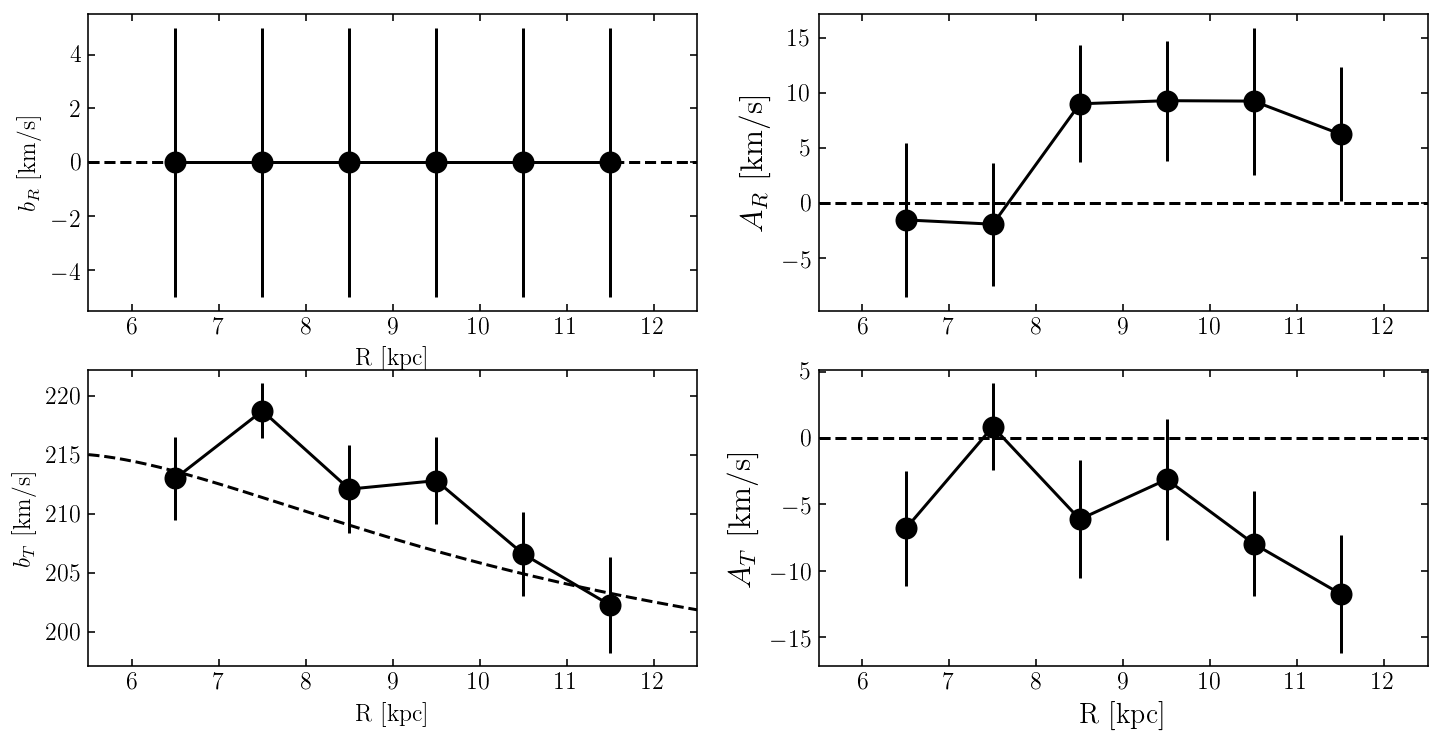

In [69]:
lm_test = ast1501.linear_model.LinearModel(instantiate_method=1, gc_R=gc_R, 
    gc_phi=gc_phi, gc_vR=gc_vR, gc_vT=gc_vT, R_lims=R_lim, 
    R_bin_size=R_bin_size, phi_lims=phi_lim, 
    phi_bin_size=phi_bin_size, phib_lims=phib_lim,
    phib_bin_size=phib_bin_size, force_yint_zero_vR=force_yint_zero,
    use_velocities=['vR','vT'])
fig,axs = lm_test.plot_vRvT_m_r(plot_kws={'markerfacecolor':None,'ecolor':'Black',
    'markeredgecolor':'Black','color':'Black','markersize':10,'marker':'o'})

matplotlib.rc('text', usetex=True)

axs[0,1].set_ylabel(r'$A_{R}$ [km/s]', fontsize=16)
axs[1,1].set_ylabel(r'$A_{T}$ [km/s]', fontsize=16)
axs[0,1].set_xlabel(r'', fontsize=14)
axs[1,1].set_xlabel(r'R [kpc]', fontsize=14)

fig.set_facecolor('White')
plt.savefig('Another_fig_for_talk.png',dpi=300)

plt.show()

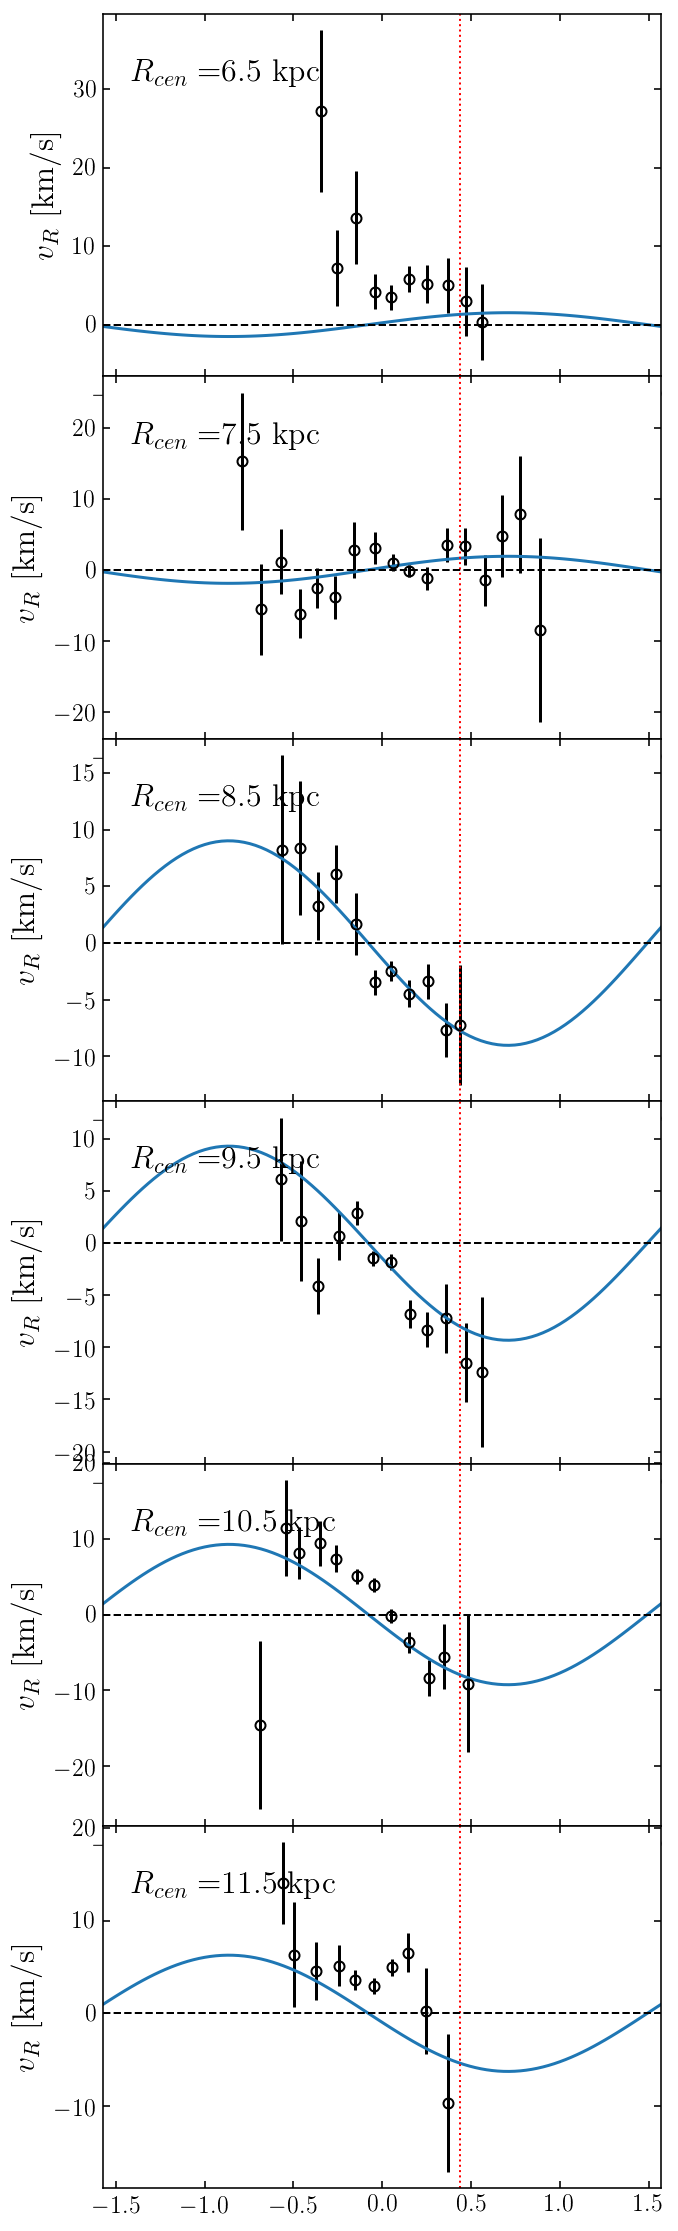

In [70]:
fig,axs = lm_test.plot_velocity_known_m_b_phi(velocity_type='vR')
fig.set_facecolor('White')
axs[0].get_legend().remove()
fig.set_size_inches(5,20)
plt.savefig('vels_for_talk1.png')
plt.show()

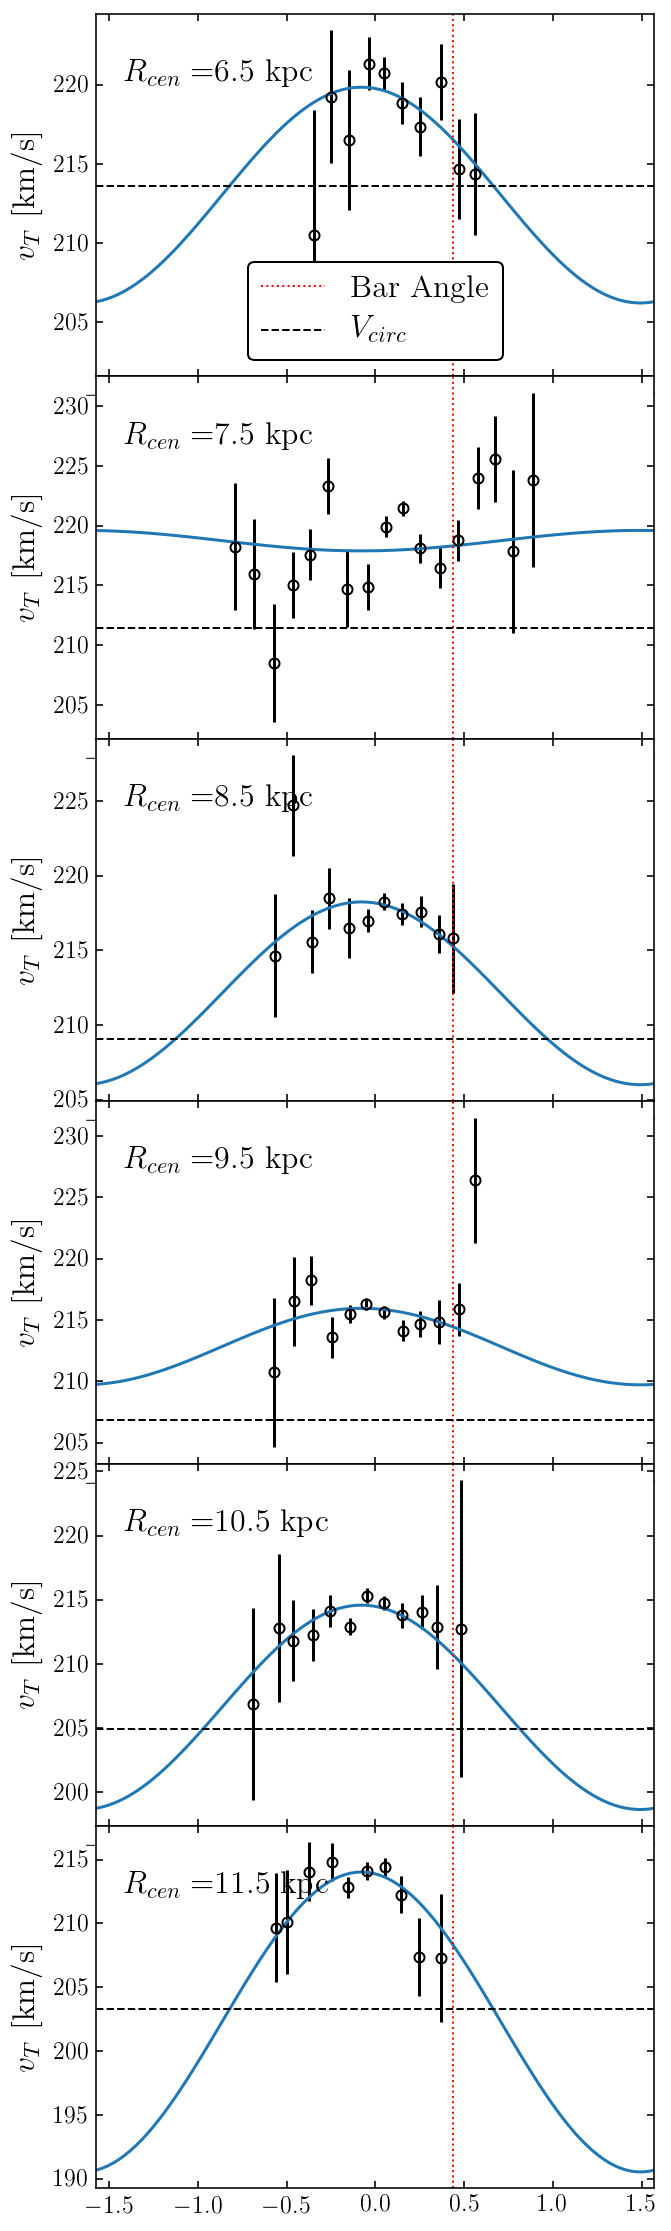

In [72]:
fig,axs = lm_test.plot_velocity_known_m_b_phi(velocity_type='vT')
fig.set_facecolor('White')
fig.set_size_inches(5,20)
plt.savefig('vels_for_talk2.png')
plt.show()

## Load bar models

In [73]:
bar_model_names = glob.glob('../../scripts/generate_lsbar_df_range/2019-06-14/*.npy')
n_bar_models = len(bar_model_names)
bar_model_af_vals = np.array([0.01,0.015,0.02,0.025,0.01,0.015,0.02,0.025,0.01,0.015,0.02,0.025])
bar_model_omegab_vals = np.array([35,35,35,35,40,40,40,40,45,45,45,45])
bar_models = []
for i in range(len(bar_model_names)):
    bar_model_data_temp = np.load(bar_model_names[i])
    bar_models.append(bar_model_data_temp)
###i

In [74]:
def interpolate_bar_model(R,phi,bar_model_data):  
    # Load data
    X_bin_cents = bar_model_data[:,2].astype(float)
    Y_bin_cents = bar_model_data[:,3].astype(float)
    vR_values = bar_model_data[:,4].astype(float)
    vT_values = bar_model_data[:,6].astype(float)
    X_cur = R*np.cos(phi)
    Y_cur = R*np.sin(phi)
        
    # Now make the interpolation grid
    interpolation_kind = 'linear'
    vR_interpolator = interpolate.interp2d(X_bin_cents, Y_bin_cents, vR_values, 
        kind=interpolation_kind)
    vT_interpolator = interpolate.interp2d(X_bin_cents, Y_bin_cents, vT_values, 
        kind=interpolation_kind)
        
    # Interpolate and return
    vR_interp = vR_interpolator(X_cur, Y_cur)
    vT_interp = vT_interpolator(X_cur, Y_cur)
    return vR_interp[0,:], vT_interp[0,:]
#def

In [127]:
n_abc_samp = 5000

# Name to pickle
pickle_filename = 'August_14_3'
check_pickle_filename(pickle_filename)

# Generate the b/a sample
b_a_mc_sample = np.random.uniform(low=0.8, high=1.0, size=n_abc_samp)

# Generate the phiB sample
phiB_mc_sample = np.random.uniform(low=0, high=np.pi, size=n_abc_samp)

# Generate the bar samples
bar_mc_sample = np.random.randint(low=0, high=n_bar_models, size=n_abc_samp)

# Array to hold ABC linear models
lm_arr = []

# Setup the Milky Way potential for calculating the circular velocity
mwpot = potential.MWPotential2014

# Generate the linear models
for i in tqdm_notebook(range(n_abc_samp)):
    
    # Generate the MC samples of the Gaia data and parameters
    b_a = b_a_mc_sample[i]
    phiB = phiB_mc_sample[i]
    
    # Make the Kuijken model for these parameters and generate the velocities
    kt = ast1501.potential.kuijken_potential(b_a=b_a, phib=phiB)
    kt_vR = kt.kuijken_vr(R=R_bin_cents_mas, phi=phi_bin_cents_mas)
    kt_vT = kt.kuijken_vt(R=R_bin_cents_mas, phi=phi_bin_cents_mas)
    
    # Sample from the normal distribution and scale by the known data errors
    kt_vR_pert = np.random.normal(loc=0.0, scale=1.0, size=n_pts_mas) * vR_err_mas
    kt_vT_pert = np.random.normal(loc=0.0, scale=1.0, size=n_pts_mas) * vT_err_mas
    
    # Interpolate on the bar model
    vR_bar, vT_bar = interpolate_bar_model(R_bin_cents_mas, phi_bin_cents_mas, 
        bar_models[bar_mc_sample[i]])
    # vT_circ = potential.vcirc(mwpot,R_bin_cents_mas/8)*220
    # vT_bar -= vT_circ
    
    # Apply the noise and bar perturbations to the simulated data
    kt_vR = kt_vR + kt_vR_pert + vR_bar
    kt_vT = kt_vT + kt_vT_pert + vT_bar
            
    # Stitch into a bootstrap sample
    kt_bs_sample_vR, kt_bs_sample_vT = \
        make_data_like_bootstrap_samples(R_bin_cents_mas,
        phi_bin_cents_mas, kt_vR, kt_vT, vT_err=vR_err_mas, vR_err=vR_err_mas,
        phi_err=phi_err_mas)
    
    # Make the linear model
    lm_kt = LinearModel(instantiate_method=3, bs_sample_vR=kt_bs_sample_vR, 
        bs_sample_vT=kt_bs_sample_vT, phib_lims=phib_lim, phib_bin_size=phib_bin_size, 
        use_velocities=use_velocities, force_yint_zero_vR=force_yint_zero)
    
    # Append the linear model
    lm_arr.append(lm_kt)
###i

# Pickle the files
with open('./'+pickle_filename+'_sample_lm.pickle','wb') as f:
    pickle.dump(lm_arr,f)
##wi
with open('./'+pickle_filename+'_master_lm.pickle','wb') as f:
    pickle.dump(lm_mas,f)
##wi# Make the posterior

A Jupyter Widget

/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=18,21 m=302 fp=1.891546 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))

/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=20,19 m=302 fp=1.769350 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))

/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knot

/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=21,18 m=302 fp=1.595856 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))

/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=18,21 m=302 fp=4.372964 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))

/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:974: RuntimeWarning: No more knot

# Make the posterior
For each sample, figure out whether or not the model data matches the observed Gaia data

In [129]:
# # Load pickled files together
fname_1 = './August_14_1_sample_lm.pickle'
fname_2 = './August_14_2_sample_lm.pickle'
fname_3 = './August_14_3_sample_lm.pickle'
fname_mas = './August_14_1_master_lm.pickle'

lm_arr_merge = []
with open(fname_1,'rb') as f:
    lm_arr_new = pickle.load(f)
    print('Adding '+str(len(lm_arr_new))+' linear models')
    lm_arr_merge.extend(lm_arr_new)
##wi
with open(fname_2,'rb') as f:
    lm_arr_new = pickle.load(f)
    print('Adding '+str(len(lm_arr_new))+' linear models')
    lm_arr_merge.extend(lm_arr_new)
##wi
with open(fname_3,'rb') as f:
    lm_arr_new = pickle.load(f)
    print('Adding '+str(len(lm_arr_new))+' linear models')
    lm_arr_merge.extend(lm_arr_new)
##wi
with open(fname_mas,'rb') as f:
    lm_mas_merge = pickle.load(f)
##wi

Adding 5000 linear models
Adding 5000 linear models
Adding 5000 linear models


In [130]:
len(lm_arr_merge)

15000

In [131]:
lm_mas = lm_mas_merge
lm_arr = lm_arr_merge

In [132]:
# How close do two amplitudes need to be for a match to occur?
epsilon = '1-sigma'
use_both_errors = False
include_vT = False # Does the circular velocity need to be subtracted from the amplitude?

lm_mas_m_vR_err = lm_mas.m_err_vR
lm_mas_m_vR = lm_mas.m_vR
lm_mas_m_vT_err = lm_mas.m_err_vT
lm_mas_m_vT = lm_mas.m_vT

# Array of matches. Will be indexed if the file is a match
matches = np.zeros(n_abc_samp)

# Loop over the samples
for i in range( n_abc_samp ):
    
    lm_kt = lm_arr[i]
    lm_kt_m_vR = lm_kt.m_vR
    lm_kt_m_vR_err = lm_kt.m_err_vR

    if include_vT:
        lm_kt_m_vT = lm_kt.m_vT - lm_kt.b_vT
        lm_kt_m_vT_err = lm_kt.m_err_vT
    ##fi
    else:
        lm_kt_m_vT = lm_kt.m_vT
        lm_kt_m_vT_err = lm_kt.m_err_vT
    ##fi
    
    good_match = 1
    
    # Evaluate the match. Will evaluate to True if all points within 1-sigma. False if 
    # any points evaluate to more than 1 sigma away from the data.
    if epsilon == '1-sigma':
        if use_both_errors:
            epsilon_error = lm_mas_m_vR_err + lm_kt_m_vR_err
            match_merit = np.all( np.abs( lm_kt_m_vR - lm_mas_m_vR ) < epsilon_error )
        else:
            match_merit_vR = np.all( np.abs( lm_kt_m_vR - lm_mas_m_vR ) < 2*lm_mas_m_vR_err )
            match_merit_vT = np.all( np.abs( lm_kt_m_vT - lm_mas_m_vT ) < 2*lm_mas_m_vT_err )
        ##ie
            
    if match_merit_vR == False or match_merit_vT == False:
        good_match = -1
    ##fi
    
    matches[i]=good_match
    
###i

In [133]:
where_good_matches = np.where( matches == 1 )[0]
where_bad_matches = np.where( matches == -1 )[0]
n_good_matches = len(where_good_matches)

good_data = np.array([ b_a_mc_sample[where_good_matches], phiB_mc_sample[where_good_matches] ,
                    bar_model_omegab_vals[bar_mc_sample[where_good_matches]], 
                    bar_model_af_vals[bar_mc_sample[where_good_matches]] ]).T

good_data_labels = [r'$b/a$',r'$\phi_{b}$ [rad]',r'$\Omega_{b}$ [km/s/kpc]',r'$A_{f}$']

In [134]:
print(str(n_good_matches)+' good matches')

136 good matches


## Plot the amplitudes

In [135]:
# n_plot = 100

# plot_linewidth = 0.5
# plot_linestyle = 'solid'
# plot_alpha = 0.5

# for i in range( n_plot ):
    
#     if i in where_good_matches:
#         plot_color='DodgerBlue'
#     else:
#         plot_color='Red'
#     ##ie
    
#     plot_kws={'color':plot_color,'linestyle':plot_linestyle,'linewidth':plot_linewidth,
#              'alpha':plot_alpha}
    
#     if i == 0:
#         fig,axs = lm_arr[i].plot_velocity_m_r(plot_kws=plot_kws, plot_type='plot')
#     else:
#         fig,axs = lm_arr[i].plot_velocity_m_r(plot_kws=plot_kws, plot_type='plot',
#                                          fig=fig, axs=axs)
#     ##ie
# ###i

# plot_kws_mas = {'color':'Black','linestyle':'solid','linewidth':0.5,
#                 'alpha':1.0}
# fig,axs = lm_mas.plot_velocity_m_r(plot_kws=plot_kws_mas, plot_type='plot', 
#                               fig=fig, axs=axs, which_velocity='vR')

# fig.set_facecolor('White')
# plt.show()

## Plot the posterior

In [136]:
# plt.rc('font', family='serif', size=16)
# plt.rc('xtick', labelsize=12)
# plt.rc('ytick', labelsize=12)
# plt.rc('text', usetex=True)

# fig, axs = staircase_plot(good_data, good_data_labels, use_kernel=False)

# b_a_median = np.median( good_data[:,0] )
# b_a_upper_68ci = np.sort( good_data[:,0] )[ int((0.5+0.68/2)*n_good_matches) ]
# b_a_lower_68ci = np.sort( good_data[:,0] )[ int((0.5-0.68/2)*n_good_matches) ]
# b_a_t1_68ci = np.sort( good_data[:,0] )[ int( (1-0.68)*n_good_matches ) ]
# b_a_t1_95ci = np.sort( good_data[:,0] )[ int( (1-0.95)*n_good_matches ) ]
# axs[0,0].axvline( b_a_median, linestyle='solid', color='DodgerBlue' )
# axs[0,0].axvline( b_a_upper_68ci, linestyle='dashed', color='DodgerBlue' )
# axs[0,0].axvline( b_a_lower_68ci, linestyle='dashed', color='DodgerBlue' )
# axs[0,0].axvline( b_a_t1_68ci, linestyle='dotted', color='Red' )
# axs[0,0].axvline( b_a_t1_95ci, linestyle='dotted', color='Red' )

# axs[1,0].set_yticks([0,np.pi/2,3*np.pi/4])
# axs[1,0].set_yticklabels([r'0',r'$\pi/2$','$3\pi/4$'])
# axs[1,1].set_xticks([0,np.pi/2,3*np.pi/4])
# axs[1,1].set_xticklabels([r'0',r'$\pi/2$','$3\pi/4$'])
# axs[1,1].set_xlabel(r'$\phi_{b}$ [rad]')

# phiB_median = np.median( good_data[:,1] )
# phiB_upper_68ci = np.sort( good_data[:,1] )[ int((0.5+0.68/2)*n_good_matches) ]
# phiB_lower_68ci = np.sort( good_data[:,1] )[ int((0.5-0.68/2)*n_good_matches) ]
# axs[1,1].axvline( phiB_median, linestyle='solid', color='DodgerBlue' )
# axs[1,1].axvline( phiB_upper_68ci, linestyle='dashed', color='DodgerBlue' )
# axs[1,1].axvline( phiB_lower_68ci, linestyle='dashed', color='DodgerBlue' )

# fig.subplots_adjust(wspace=0, hspace=0)
# fig.set_facecolor('White')
# fig.savefig('fig5.pdf')
# plt.show()

# print('b/a:')
# print('Median: '+str(b_a_median))
# print('68% CI: '+str(b_a_lower_68ci)+', '+str(b_a_upper_68ci))
# print('68% to 1 '+str(b_a_t1_68ci))
# print('95% to 1 '+str(b_a_t1_95ci))
# print('\nphiB:')
# print('Median: '+str(phiB_median))
# print('68% CI: '+str(phiB_lower_68ci)+', '+str(phiB_upper_68ci))

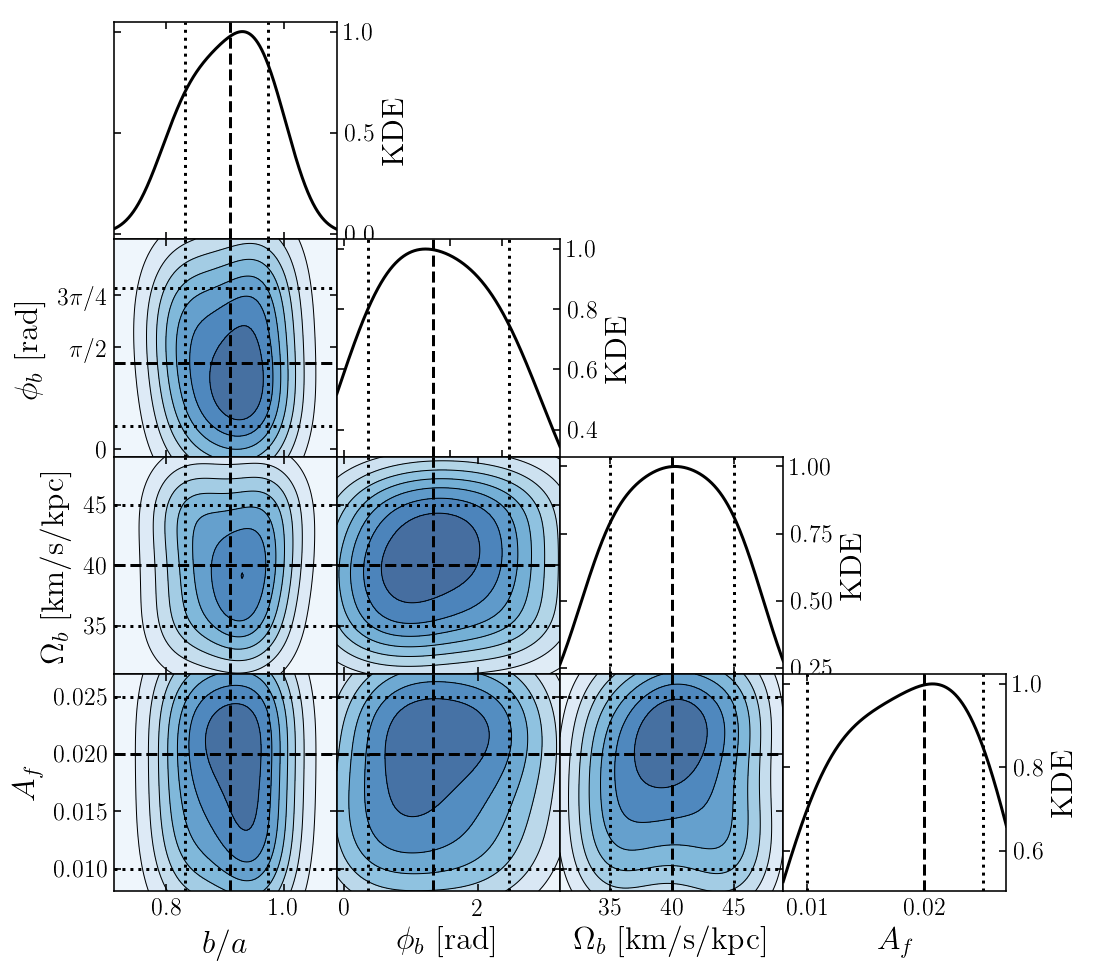

b/a:
Median: 0.9082609798709498
68% CI: 0.8313104269436679, 0.972565749213683

phiB:


NameError: name 'phiB_median' is not defined

In [137]:
plt.rc('font', family='serif', size=16)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('text', usetex=True)

fig, axs = staircase_plot(good_data, good_data_labels, use_kernel=True, plot_ci=True)

b_a_median = np.median( good_data[:,0] )
b_a_upper_68ci = np.sort( good_data[:,0] )[ int((0.5+0.68/2)*n_good_matches) ]
b_a_lower_68ci = np.sort( good_data[:,0] )[ int((0.5-0.68/2)*n_good_matches) ]
b_a_t1_68ci = np.sort( good_data[:,0] )[ int( (1-0.68)*n_good_matches ) ]
b_a_t1_95ci = np.sort( good_data[:,0] )[ int( (1-0.95)*n_good_matches ) ]
# axs[0,0].axvline( b_a_median, linestyle='solid', color='DodgerBlue' )
# axs[0,0].axvline( b_a_upper_68ci, linestyle='dashed', color='DodgerBlue' )
# axs[0,0].axvline( b_a_lower_68ci, linestyle='dashed', color='DodgerBlue' )
# axs[0,0].axvline( b_a_t1_68ci, linestyle='dotted', color='Red' )
# axs[0,0].axvline( b_a_t1_95ci, linestyle='dotted', color='Red' )

axs[1,0].set_yticks([0,np.pi/2,3*np.pi/4])
axs[1,0].set_yticklabels([r'0',r'$\pi/2$','$3\pi/4$'])
axs[1,1].set_xticks([0,np.pi/2,3*np.pi/4])
axs[1,1].set_xticklabels([r'0',r'$\pi/2$','$3\pi/4$'])
axs[1,1].set_xlabel(r'$\phi_{b}$ [rad]')

fig.subplots_adjust(wspace=0, hspace=0)
fig.set_facecolor('White')
fig.savefig('fig5_dr16.pdf')
plt.show()

print('b/a:')
print('Median: '+str(b_a_median))
print('68% CI: '+str(b_a_lower_68ci)+', '+str(b_a_upper_68ci))
print('\nphiB:')
print('Median: '+str(phiB_median))
print('68% CI: '+str(phiB_lower_68ci)+', '+str(phiB_upper_68ci))

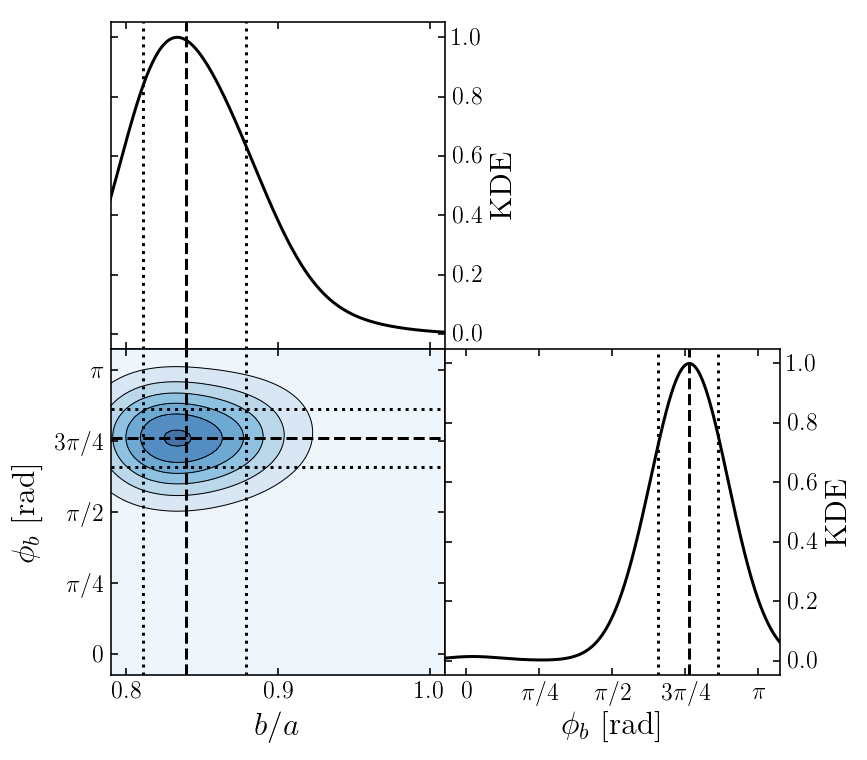

b/a:
Median: 0.8394277562914851
68% CI: 0.8113805826080108, 0.8787192931886298


In [126]:
good_data = np.array([ b_a_mc_sample[where_good_matches], phiB_mc_sample[where_good_matches] 
                     ]).T

good_data_labels = [r'$b/a$',r'$\phi_{b}$ [rad]']

plt.rc('font', family='serif', size=16)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('text', usetex=True)

fig, axs = staircase_plot(good_data, good_data_labels, use_kernel=True, plot_ci=True)

axs[1,0].set_yticks([0,np.pi/4,np.pi/2,3*np.pi/4,np.pi])
axs[1,0].set_yticklabels([r'0',r'$\pi/4$',r'$\pi/2$',r'$3\pi/4$',r'$\pi$'])
axs[1,1].set_xticks([0,np.pi/4,np.pi/2,3*np.pi/4,np.pi])
axs[1,1].set_xticklabels([r'0',r'$\pi/4$',r'$\pi/2$',r'$3\pi/4$',r'$\pi$'])
axs[1,1].set_xlabel(r'$\phi_{b}$ [rad]')

axs[0,0].set_xlim(0.79,1.01)
axs[1,0].set_xlim(0.79,1.01)

fig.subplots_adjust(wspace=0, hspace=0)
fig.set_facecolor('White')
fig.savefig('abc_trihalo_parms_dr16.pdf')
plt.show()

b_a_median = np.median( good_data[:,0] )
b_a_upper_68ci = np.sort( good_data[:,0] )[ int((0.5+0.68/2)*n_good_matches) ]
b_a_lower_68ci = np.sort( good_data[:,0] )[ int((0.5-0.68/2)*n_good_matches) ]
b_a_t1_68ci = np.sort( good_data[:,0] )[ int( (1-0.68)*n_good_matches ) ]
b_a_t1_95ci = np.sort( good_data[:,0] )[ int( (1-0.95)*n_good_matches ) ]

print('b/a:')
print('Median: '+str(b_a_median))
print('68% CI: '+str(b_a_lower_68ci)+', '+str(b_a_upper_68ci))
# print('\nphiB:')
# print('Median: '+str(phiB_median))
# print('68% CI: '+str(phiB_lower_68ci)+', '+str(phiB_upper_68ci))

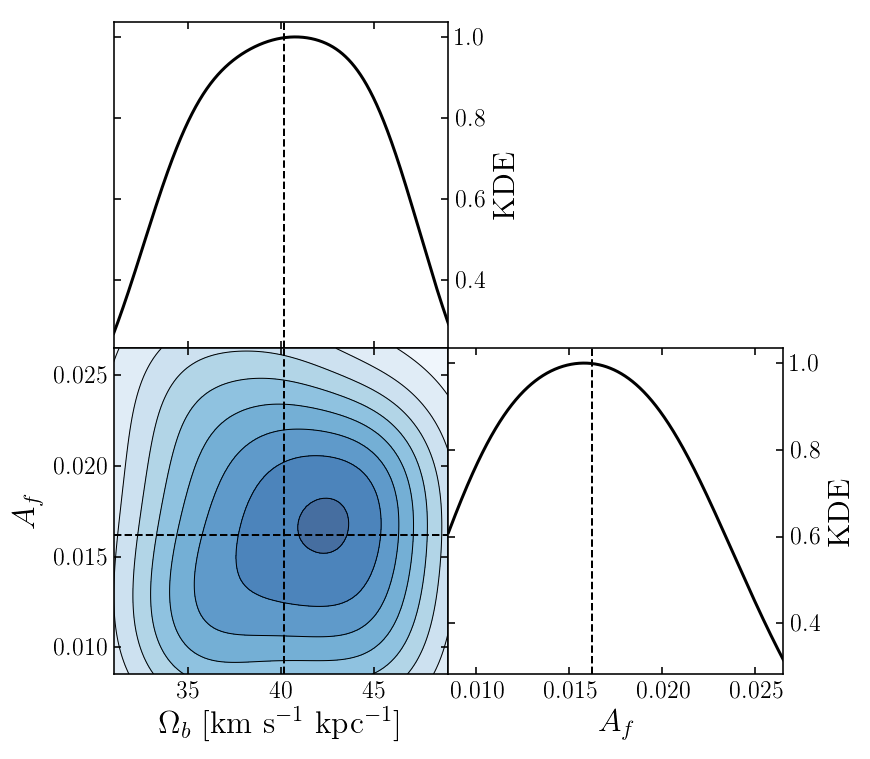

In [125]:
good_data = np.array([bar_model_omegab_vals[bar_mc_sample[where_good_matches]], 
                    bar_model_af_vals[bar_mc_sample[where_good_matches]] ]).T

good_data_labels = [r'$\Omega_{b}$ [km s$^{-1}$ kpc$^{-1}$]',r'$A_{f}$']

plt.rc('font', family='serif', size=16)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('text', usetex=True)

fig, axs = staircase_plot(good_data, good_data_labels, use_kernel=True, plot_ci=False)

# axs[1,0].set_yticks([0,np.pi/4,np.pi/2,3*np.pi/4,np.pi])
# axs[1,0].set_yticklabels([r'0',r'$\pi/4$',r'$\pi/2$',r'$3\pi/4$',r'$\pi$'])
# axs[1,1].set_xticks([0,np.pi/4,np.pi/2,3*np.pi/4,np.pi])
# axs[1,1].set_xticklabels([r'0',r'$\pi/4$',r'$\pi/2$',r'$3\pi/4$',r'$\pi$'])
# axs[1,1].set_xlabel(r'$\phi_{b}$ [rad]')

# axs[0,0].set_xlim(0.79,1.01)
# axs[1,0].set_xlim(0.79,1.01)

omegab_avg = np.average(good_data.T[0])
af_avg = np.average(good_data.T[1])

axs[0,0].axvline(omegab_avg, linestyle='dashed', linewidth=1., color='Black')
axs[1,1].axvline(af_avg, linestyle='dashed', linewidth=1., color='Black')
axs[1,0].axvline(omegab_avg, linestyle='dashed', linewidth=1., color='Black')
axs[1,0].axhline(af_avg, linestyle='dashed', linewidth=1., color='Black')

fig.subplots_adjust(wspace=0, hspace=0)
fig.set_facecolor('White')
fig.savefig('abc_trihalo_bar_parms_dr16.pdf')
plt.show()
